# Cars 4 You: predictive price model

#### Group 23: Alexandre Coelho 20250475, Bernardo Pacheco 20250486, Bruna Sousa 20250526, Rui Sousa 20250473

## Introduction

This notebook implements an end-to-end Machine Learning pipeline for Cars 4 You. The objective is to predict the price of a car based on user-submitted data.

## Load libraries

We began by loading the necessary libraries.

In [169]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


from rapidfuzz import fuzz, process

import scipy.stats as stats
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings('ignore')


In [170]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import category_encoders as ce

## Exploratory data analysis and data quality

We started by loading and performing an in-depth analysis of the data quality to identify missing values, outliers, and formatting errors.

### Data loading and initial inspection

In [171]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [172]:
train.head(3)

,carID,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
0,69512,VW,Golf,2016.0,22290,Semi-Auto,28421.0,Petrol,NaN,11.417268,2.0,63.0,4.0,0.0
1,53000,Toyota,Yaris,2019.0,13790,Manual,4589.0,Petrol,145.0,47.900000,1.5,50.0,1.0,0.0
2,6366,Audi,Q2,2019.0,24990,Semi-Auto,3624.0,Petrol,145.0,40.900000,1.5,56.0,4.0,0.0


We can see that transmission is in the database but it wasn´t included in the metadata.

In [173]:
train.duplicated("carID").sum()

np.int64(0)

No carID duplicated, so we can define it as the index.

In [174]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75973 entries, 0 to 75972
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   carID           75973 non-null  int64  
 1   Brand           74452 non-null  object 
 2   model           74456 non-null  object 
 3   year            74482 non-null  float64
 4   price           75973 non-null  int64  
 5   transmission    74451 non-null  object 
 6   mileage         74510 non-null  float64
 7   fuelType        74462 non-null  object 
 8   tax             68069 non-null  float64
 9   mpg             68047 non-null  float64
 10  engineSize      74457 non-null  float64
 11  paintQuality%   74449 non-null  float64
 12  previousOwners  74423 non-null  float64
 13  hasDamage       74425 non-null  float64
dtypes: float64(8), int64(2), object(4)
memory usage: 8.1+ MB


We can conclude that we have many strange values in all columns and some Dtypes are wrong (year and previousOwners).

In [175]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
carID,75973.0,37986.000000,21931.660338,0.000000,18993.00,37986.0,56979.0,75972.000000
year,74482.0,2017.096611,2.208704,1970.000000,2016.00,2017.0,2019.0,2024.121759
price,75973.0,16881.889553,9736.926322,450.000000,10200.00,14699.0,20950.0,159999.000000
mileage,74510.0,23004.184088,22129.788366,-58540.574478,7423.25,17300.0,32427.5,323000.000000
tax,68069.0,120.329078,65.521176,-91.121630,125.00,145.0,145.0,580.000000
mpg,68047.0,55.152666,16.497837,-43.421768,46.30,54.3,62.8,470.800000
engineSize,74457.0,1.660136,0.573462,-0.103493,1.20,1.6,2.0,6.600000
paintQuality%,74449.0,64.590667,21.021065,1.638913,47.00,65.0,82.0,125.594308
previousOwners,74423.0,1.994580,1.472981,-2.345650,1.00,2.0,3.0,6.258371
hasDamage,74425.0,0.000000,0.000000,0.000000,0.00,0.0,0.0,0.000000


Here we can detect many strange values as:
    2024.121759 in the year column;
    -58540.574478 in the mileage column;
    -91.121630 in the tax column;
    -43.421768 in the mpg column;
    -0.103493 in the engineSize column;
    125.594308 in the paintQuality% column;
    -2.345650 in the previousOwners column;
    just zeros in the hasDamage column.

In [176]:
train.hasDamage.value_counts()

hasDamage
0.0    74425
Name: count, dtype: int64

By looking at this result, we can conclude that the stand only sells cars that have no damage at all.

In [177]:
metric_features = ['year', 'mileage','tax','mpg', 'engineSize', 'paintQuality%', 'previousOwners', 'hasDamage']
non_metric_features = train.columns.drop(metric_features).to_list()
non_metric_features.remove("carID")
non_metric_features.remove("price")

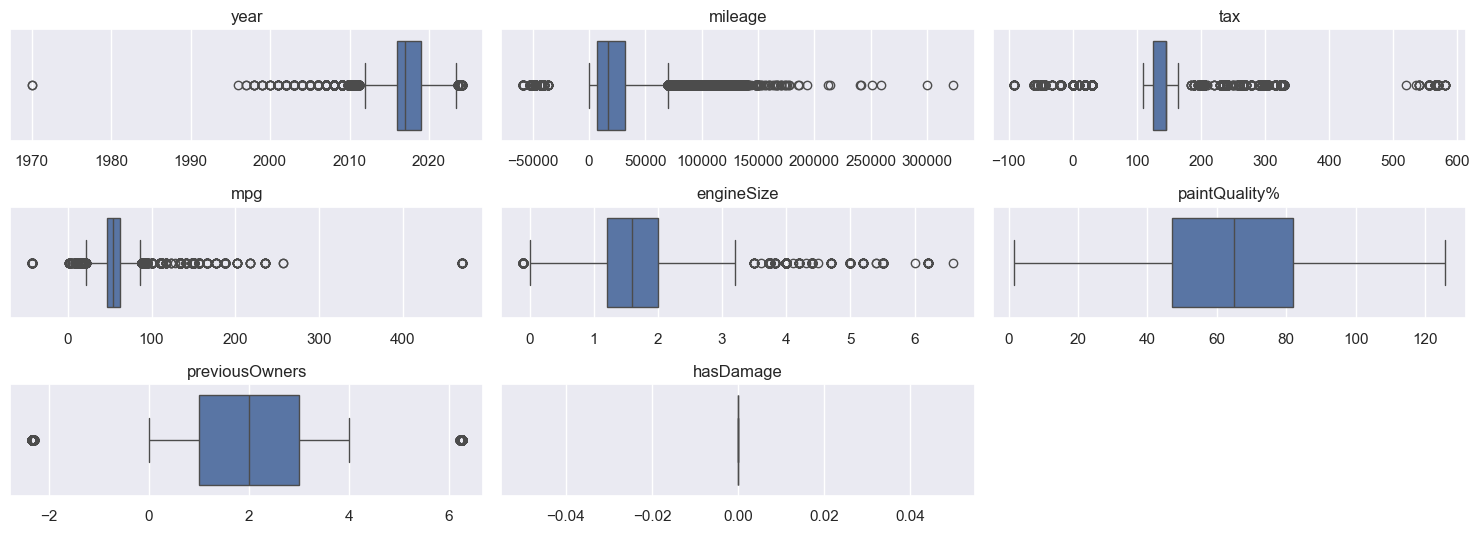

In [178]:
plt.figure(figsize=(15, 7))
for i, col in enumerate(metric_features):
    plt.subplot(4, 3, i + 1) # Cria uma grelha 2x2
    sns.boxplot(x=train[col])
    plt.title(col)
    plt.xlabel("")

plt.tight_layout()
plt.show()

### Missing values

In [179]:
print(train.isna().sum())

carID                0
Brand             1521
model             1517
year              1491
price                0
transmission      1522
mileage           1463
fuelType          1511
tax               7904
mpg               7926
engineSize        1516
paintQuality%     1524
previousOwners    1550
hasDamage         1548
dtype: int64


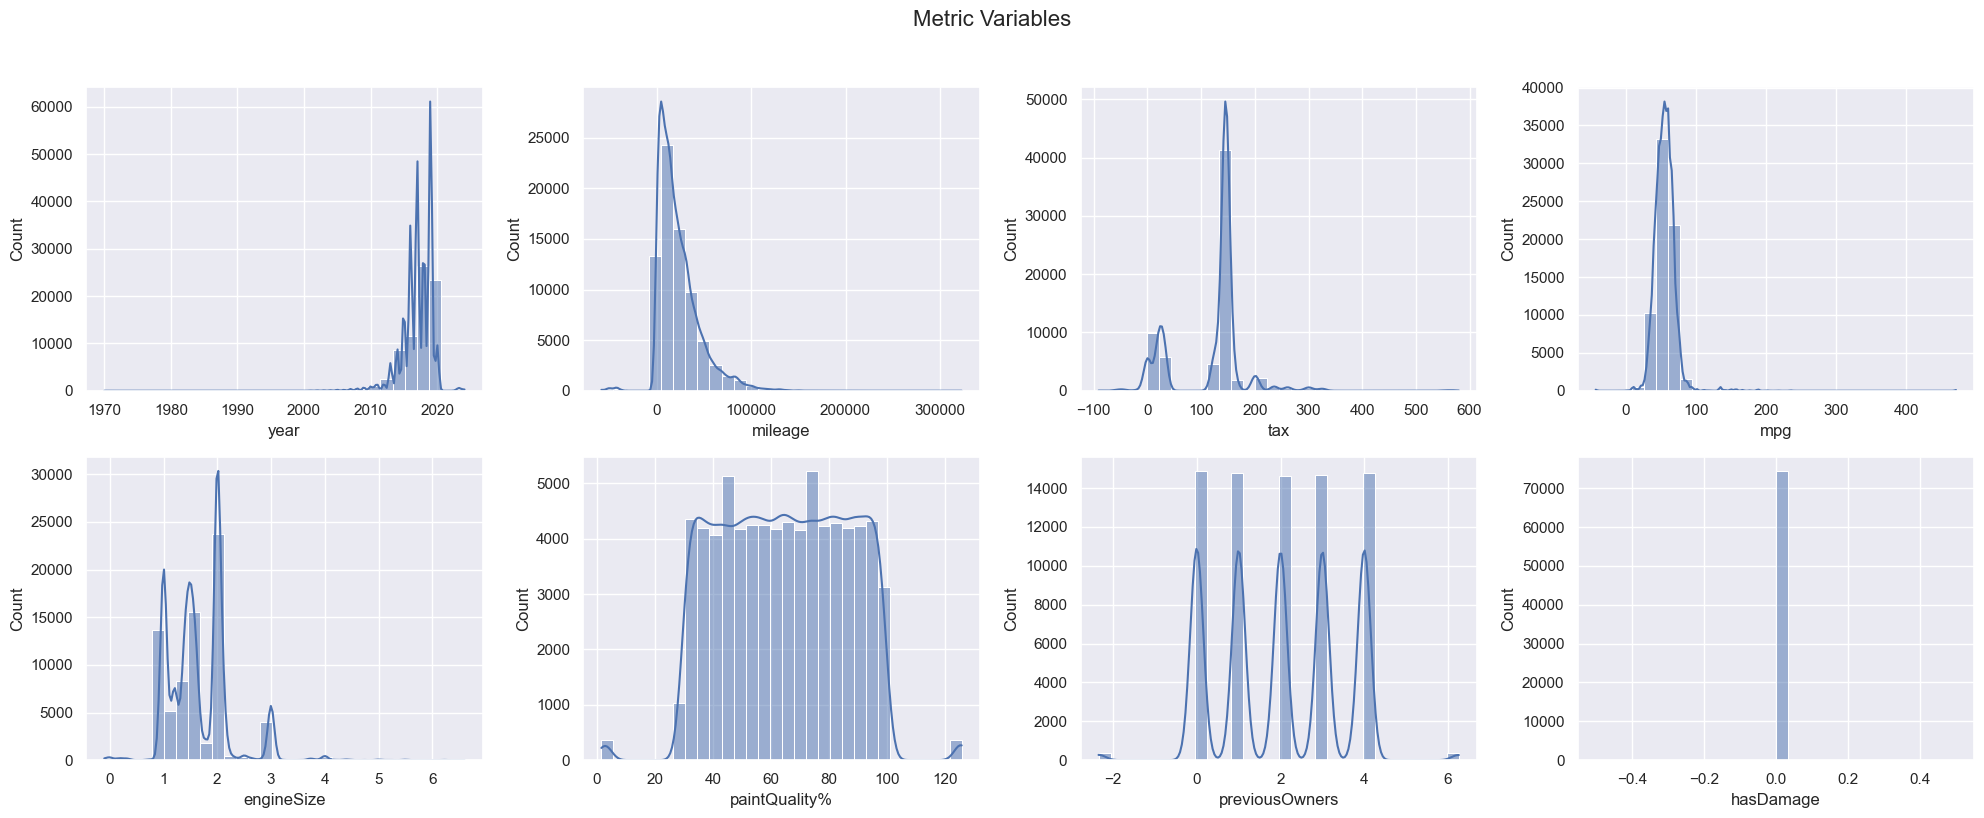

In [180]:
sp_rows = 2
sp_cols = 4

# Prepare figure and axes
fig, axes = plt.subplots(sp_rows, sp_cols, figsize=(20, 8), tight_layout=True)

# Plot data with seaborn
features = [f for f in metric_features]

for ax, feat in zip(axes.flatten(), features):
    sns.histplot(train[feat], bins=30, kde=True, ax=ax)

# Add a centered title to the figure
title = "Metric Variables"
fig.suptitle(title, fontsize=16, y=1.02)

plt.show()


From the histograms, we can observe that most of the metric variables are right-skewed and contain several outliers. Because of this non-normal distribution, replacing missing values with the median is more appropriate than using the mean, as the median is less affected by extreme values and better represents the central tendency of skewed data.

## Data preprocessing and cleaning

### Numerical feature cleaning

First, we defined functions to correct data types like year to Int64 and replace strange values (negative or >100%) with NaN.

In [181]:
def strange_values_to_nan(f,column,limit):
    strange_values = f[column] < limit
    f.loc[strange_values, column] = np.nan 
    print(f"Found {strange_values.sum()} strange values in {column}.")

In [182]:
def pre_processing_metric(df):
    #setting carID as index
    df.set_index("carID", inplace=True)

    #fixing the types
    df["year"]=[int(i) if isinstance(i, float) and not pd.isna(i) else i for i in df["year"]]
    df["year"] = df["year"].astype("Int64")
    df["previousOwners"]=[int(i) if isinstance(i, float) and not pd.isna(i) else i for i in df["previousOwners"]]
    df["previousOwners"] = df["previousOwners"].astype("Int64")

    #converting strange values to nan
    strange_values_to_nan(df,"mileage",0)
    strange_values_to_nan(df,"tax",0)
    strange_values_to_nan(df,"mpg",10)
    strange_values_to_nan(df,"engineSize",1)
    strange_values_to_nan(df,"previousOwners",0)
    df.loc[df["paintQuality%"] > 100, "paintQuality%"] = np.nan 

    #deleting column hasDamage because it has the same value in all rows
    del df["hasDamage"]
        

In [183]:
metric_features.remove("hasDamage") 

We removed hasDamage from metric_features list, as we decided to delete this column because it presented the same value in all rows.

In [184]:
X=[train,test]
for f in X:
    pre_processing_metric(f)

Found 369 strange values in mileage.
Found 378 strange values in tax.
Found 151 strange values in mpg.
Found 574 strange values in engineSize.
Found 371 strange values in previousOwners.
Found 170 strange values in mileage.
Found 161 strange values in tax.
Found 74 strange values in mpg.
Found 245 strange values in engineSize.
Found 168 strange values in previousOwners.


In [185]:
train.head(3)

,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners
carID,,,,,,,,,,,,
69512,VW,Golf,2016,22290,Semi-Auto,28421.0,Petrol,NaN,11.417268,2.0,63.0,4
53000,Toyota,Yaris,2019,13790,Manual,4589.0,Petrol,145.0,47.900000,1.5,50.0,1
6366,Audi,Q2,2019,24990,Semi-Auto,3624.0,Petrol,145.0,40.900000,1.5,56.0,4


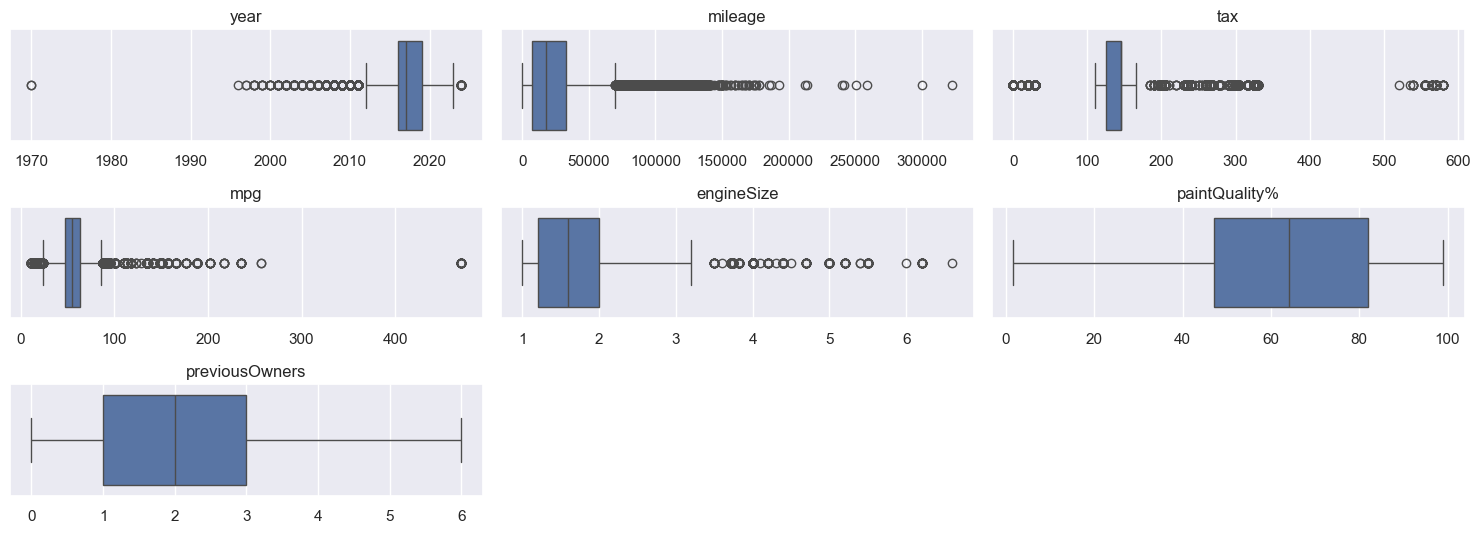

In [186]:
plt.figure(figsize=(15, 7))
for i, col in enumerate(metric_features):
    plt.subplot(4, 3, i + 1) # Cria uma grelha 2x2
    sns.boxplot(x=train[col])
    plt.title(col)
    plt.xlabel("")

plt.tight_layout()
plt.show()

### Categorical feature cleaning

For text features like brand and transmission, we used rapidfuzz to standardize inconsistent entries (per example, "Ford" vs "ford") and fill remaining NaNs with "Unknown".

In [187]:
def build_valid_dic(column, valid_list, cuttoff):
    #first, clean de column and the valid list
    unique_column_values = [str(v).strip().lower() for v in column.dropna().unique()]
    #secound, creat the dic with the valid values with empyt similar words
    result = {valid_word: [] for valid_word in valid_list}

    for valid in valid_list:
        valid_lower = valid.lower()
        fuzzy_matched_values = process.extract(
            valid_lower, #the check valeu
            unique_column_values, #the list that we are going to use to check
            scorer = fuzz.token_sort_ratio,
            score_cutoff = cuttoff
        )
        for match_value, score, _ in fuzzy_matched_values:
            if match_value != valid_lower:
                result[valid].append(match_value)

    return result


def replace_invalid_values(column, valid_dic):
    corrected = []
    for val in column:
        if pd.isna(val):
            corrected.append(val)
            continue
        valeu_cleaned = str(val).strip().lower()
        found = False
        for key in valid_dic:
            if valeu_cleaned == key.lower():
                corrected.append(key)
                found = True
                break
        if not found:
            for valid_key, variations in valid_dic.items():
                if valeu_cleaned in [v.lower() for v in variations]:
                    corrected.append(valid_key)
                    found = True
                    break
        if not found:
            corrected.append(val)

    return corrected
def fill_nans_categorical(data, columns):
    for col in columns:
        data[col] =data[col].fillna("Unknown")
    return data


def dic_brand_modles(brands, models, valid_brands):
    result = {brand: [] for brand in valid_brands}
    for brand, model in zip(brands,models):
        if pd.isna(brand) or pd.isna(model):
            continue
        model_clean = str(model).strip().lower()
        if model_clean not in result[brand]:
            result[brand].append(model_clean)

    return result

def pre_processing_non_metric(dic_col_valid, data):
    for i in range(1,4):
        for key,values in dic_col_valid.items():
            valid_dic = build_valid_dic(data[key],values, cuttoff= 50)
            data[key] = replace_invalid_values(data[key], valid_dic)
            if i == 3:
                print(data[key].value_counts())
                
                
def valid_models_dict(data, brands, min_count=0):
    models_dict = {}
    for brand in brands:
        brands_frame = data[data["Brand"] == brand]
        models_clean = brands_frame["model"].astype(str).str.strip().str.lower()
        models_count = models_clean.value_counts()
        models_count = models_count[models_count >= min_count]
        potential_models = models_count.index.tolist()
        valid_models_for_brand = []

        for model in potential_models:
            is_truncated = False
            for valid_model in valid_models_for_brand:
                if valid_model.startswith(model):
                   
                    is_truncated = True
                    break

            if not is_truncated:
                valid_models_for_brand.append(model)

        models_dict[brand] = valid_models_for_brand

    return models_dict

def fill_unknown_brand(data,valid_models_dict):
    unknown_df = data[data['Brand'] == 'Unknown']
    for idx,row in unknown_df.iterrows():
        model_lower = str(row['model']).lower()
        for brand, models in valid_models_dict.items():
            if model_lower in [m.lower() for m in models]: 
                data.at[idx, 'Brand'] = brand
                break 

    return data
        

In [188]:
valid_brands_list = ["Ford", "Mercedes", "VW", "Opel", "BMW", "Audi", "Toyota","Skoda", "Hyundai", "Unknown"]
valid_transmition_list = ["Manual", "Semi-Auto", "Automatic", "Other", "Unknown"]
valid_fueltype_list = ["Petrol" ,"Diesel", "Hybrid" , "Other", "Electric", "Unknown"]
cols_change_dic = {"Brand" : valid_brands_list,
                   "transmission" : valid_transmition_list,
                   "fuelType" : valid_fueltype_list
                   }

In [189]:
for f in X:
    fill_nans_categorical(f, non_metric_features)
    pre_processing_non_metric(cols_change_dic, f)

Brand
Ford        16065
Mercedes    11674
VW          10385
Opel         9352
BMW          7392
Audi         7325
Toyota       4622
Skoda        4301
Hyundai      3336
Unknown      1521
Name: count, dtype: int64
transmission
Manual       41627
Semi-Auto    16872
Automatic    15211
Unknown       2258
Other            5
Name: count, dtype: int64
fuelType
Petrol      41163
Diesel      30885
Hybrid       2225
Unknown      1511
Other         167
Electric       22
Name: count, dtype: int64
Brand
Ford        6891
Mercedes    5004
VW          4466
Opel        4008
BMW         3174
Audi        3130
Toyota      1982
Skoda       1836
Hyundai     1427
Unknown      649
Name: count, dtype: int64
transmission
Manual       17889
Semi-Auto     7267
Automatic     6440
Unknown        968
Other            3
Name: count, dtype: int64
fuelType
Petrol      17488
Diesel      13395
Hybrid        936
Unknown       656
Other          82
Electric       10
Name: count, dtype: int64


In [190]:
valid_models = valid_models_dict(train,valid_brands_list)

In [191]:
for f in X:
    for brand ,valid_models_list in valid_models.items():
        brand_rows = f[f["Brand"] == brand]
        pre_processing_non_metric({"model": valid_models_list}, brand_rows)
        f.loc[brand_rows.index, "model"] = brand_rows["model"]

model
focus                    6756
fiesta                   4396
kuga                     1628
ecosport                  803
c-max                     378
ka+                       354
mondeo                    345
unknown                   324
b-max                     243
s-max                     197
grand c-max               147
galaxy                    143
edge                      134
puma                       51
tourneo custom             50
grand tourneo connect      41
mustang                    37
tourneo connect            20
fusion                     12
streetka                    2
fabia                       1
escort                      1
ranger                      1
octavia                     1
Name: count, dtype: int64
model
c class      5189
a class      1694
e class      1286
glc class     657
gla class     547
b class       412
cl class      324
gle class     322
unknown       230
sl class      177
cls class     153
v class       136
s class       129
gl class

In [192]:
for f in X:
    f = fill_unknown_brand(f,valid_models)

### Data splitting (Hold-Out Method)

In [193]:
X_train_val = train.drop('price', axis=1) 
y_train_val = train['price']
X_test = test.copy()

We implemented the Hold-Out Method, splitting 'train.csv' into 75% for training (X_train) and 25% for validation (X_val).

In [194]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val, 
    test_size=0.25, 
    random_state=21,
    shuffle=True
)

In [195]:
print('train:{}% | validation:{}%'.format(round(len(y_train)/len(y_train_val),2),
                                                     round(len(y_val)/len(y_train_val),2),))

train:0.75% | validation:0.25%


In [196]:
X_features = [X_train, X_val, X_test]

### Imputation and scaling

In [197]:
def impute_numeric_features(X_features_list, metric_features):

    imputer = SimpleImputer(strategy='median')
    
    X_train_numeric_to_fit = X_features_list[0][metric_features]
    
    imputer.fit(X_train_numeric_to_fit)
    
    imputed_dfs_list = []
    
    for df in X_features_list:
    
        df_copy = df.copy() 
        
        imputed_data_np = imputer.transform(df_copy[metric_features])
        
        df_copy[metric_features] = imputed_data_np
        
        imputed_dfs_list.append(df_copy)
    return imputed_dfs_list

X_features_imputed=impute_numeric_features(X_features,metric_features)

In [198]:
def scale_numeric_features(X_features, metric_features):

    scaler = RobustScaler() 

    X_train = X_features[0].copy()
    scaler.fit(X_train[metric_features])

    
    scaled_features_list =[]

    for i,X, in enumerate(X_features):
        X_scaled = X.copy()
        X_scaled[metric_features] = scaler.transform(X[metric_features])
        scaled_features_list.append(X_scaled)

    return scaled_features_list
X_train_scaled, X_val_scaled, X_test_scaled = scale_numeric_features(X_features_imputed, metric_features)
X_features_scaled=[X_train_scaled, X_val_scaled, X_test_scaled]
X_train_num_scaled = X_train_scaled[metric_features]
X_val_num_scaled = X_val_scaled[metric_features]

print(X_train_num_scaled.min())
print(X_train_num_scaled.max())

year             -15.666667
mileage           -0.717806
tax               -7.250000
mpg               -3.176499
engineSize        -0.857143
paintQuality%     -1.781745
previousOwners    -1.000000
dtype: float64
year               2.333333
mileage           11.581772
tax               21.750000
mpg               30.851852
engineSize         7.142857
paintQuality%      1.000000
previousOwners     2.000000
dtype: float64


## Feature selection

In [199]:
X_train_num_scaled[metric_features].var()

year              0.528838
mileage           0.776598
tax               9.499812
mpg               1.364956
engineSize        0.624427
paintQuality%     0.338452
previousOwners    0.505882
dtype: float64

### Filter methods

#### Spearman correlation

In [200]:
cor_spearman = X_train_num_scaled.corr(method ='spearman')
cor_spearman

,year,mileage,tax,mpg,engineSize,paintQuality%,previousOwners
year,1.000000,-0.769962,0.303271,-0.294803,-0.040770,0.004020,0.004372
mileage,-0.769962,1.000000,-0.243356,0.305451,0.102233,-0.002679,-0.000446
tax,0.303271,-0.243356,1.000000,-0.540430,0.148026,0.001716,0.000523
mpg,-0.294803,0.305451,-0.540430,1.000000,-0.181478,0.001428,-0.000899
engineSize,-0.040770,0.102233,0.148026,-0.181478,1.000000,-0.000357,0.000020
paintQuality%,0.004020,-0.002679,0.001716,0.001428,-0.000357,1.000000,-0.005251
previousOwners,0.004372,-0.000446,0.000523,-0.000899,0.000020,-0.005251,1.000000


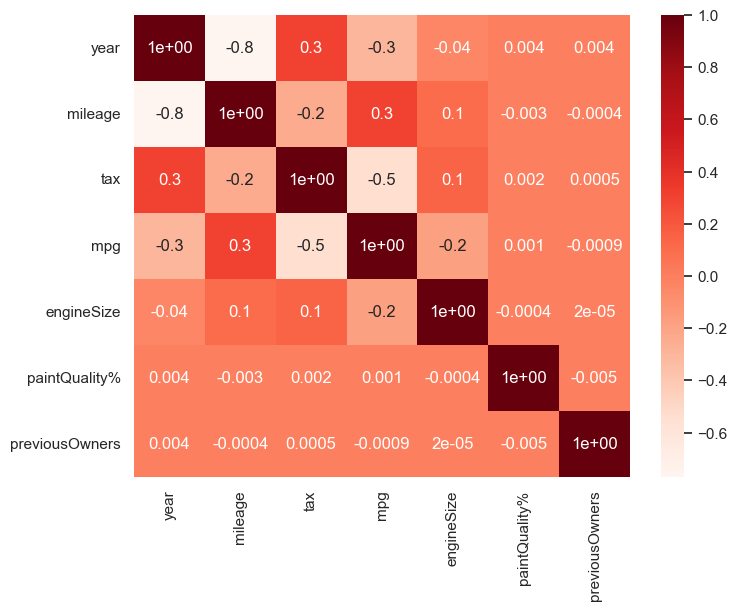

In [201]:
def cor_heatmap(cor):
    plt.figure(figsize=(8,6))
    sns.heatmap(data = cor, annot = True, cmap = plt.cm.Reds, fmt='.1')
    plt.show()

cor_heatmap (cor_spearman)

#### Chi2

In [202]:
def testindependence1(X,y,var,alpha=0.05):        
    dfObserved = pd.crosstab(y,X) 
    chi2, p, dof, expected = stats.chi2_contingency(dfObserved.values)
    dfExpected = pd.DataFrame(expected, columns=dfObserved.columns, index = dfObserved.index)
    if p<alpha:
        result="{0} is IMPORTANT for Prediction".format(var)
    else:
        result="{0} is NOT an important predictor. (Discard {0} from model)".format(var)
    print(result)

In [203]:
X_train_cat=X_train_scaled[non_metric_features]
for var in X_train_cat:
    testindependence1(X_train_cat[var],y_train, var)

Brand is IMPORTANT for Prediction
model is IMPORTANT for Prediction
transmission is IMPORTANT for Prediction
fuelType is IMPORTANT for Prediction


### Wrapper method

#### RFE

In [204]:

nof_list=np.arange(1,len(X_train_num_scaled.columns)+1)            
high_score=0
nof=0           
train_score_list =[]
val_score_list = []

for n in range(len(nof_list)):
    model = LinearRegression()
    
    rfe = RFE(estimator = model,n_features_to_select = nof_list[n])
    
    X_train_rfe = rfe.fit_transform(X_train_num_scaled,y_train)
    X_val_rfe = rfe.transform(X_val_num_scaled)
    
    model.fit(X_train_rfe,y_train)
    
    train_score = model.score(X_train_rfe,y_train)
    train_score_list.append(train_score)
    
    val_score = model.score(X_val_rfe,y_val)
    val_score_list.append(val_score)
    
    if(val_score > high_score):
        high_score = val_score
        nof = nof_list[n]
        
        features_to_select = pd.Series(rfe.support_, index = X_train_num_scaled.columns)
        
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))
print(f"Features to select: \n{features_to_select}")

Optimum number of features: 7
Score with 7 features: 0.686295
Features to select: 
year              True
mileage           True
tax               True
mpg               True
engineSize        True
paintQuality%     True
previousOwners    True
dtype: bool


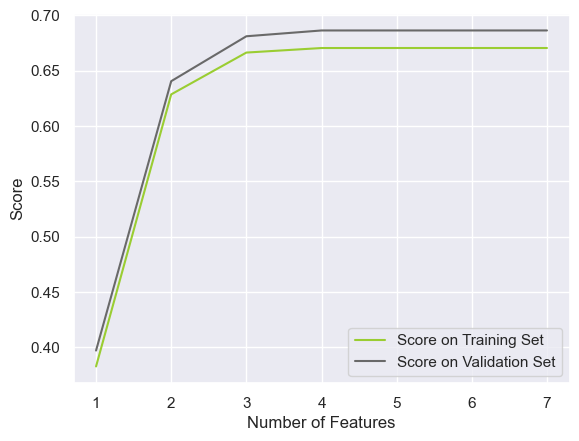

In [205]:
plt.plot(list(range(1,8)), train_score_list, label="Score on Training Set", color='yellowgreen')
plt.plot(list(range(1,8)), val_score_list, label="Score on Validation Set", color='dimgray')
plt.xlabel("Number of Features")
plt.ylabel("Score")
plt.legend()
plt.show()

### Embedded method

#### Lasso Regression 

Lasso picked 6 variables and eliminated the other 1 variables
mileage          -2775.179602
mpg               -547.508683
paintQuality%      -21.611668
previousOwners       0.000000
tax                  0.940017
year              4267.664744
engineSize        7957.383889
dtype: float64


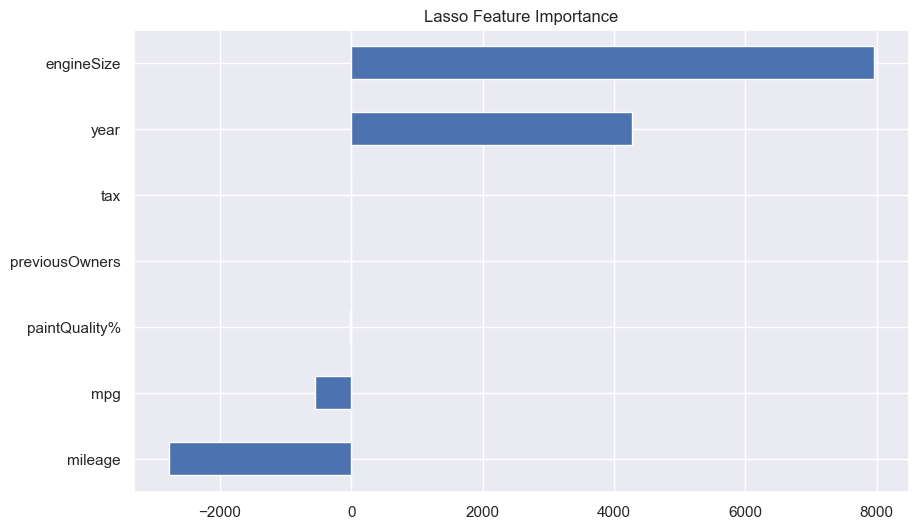

In [206]:
def plot_importance(coef, title):
    imp_coef = coef.sort_values()
    plt.figure(figsize=(10,6))
    imp_coef.plot(kind="barh")
    plt.title(title)
    plt.show()

numeric_cols = metric_features  
X_train_num_scaled = X_train_scaled[numeric_cols]

# LassoCV
reg = LassoCV(cv=5, random_state=42)
reg.fit(X_train_num_scaled, y_train)

# Coeficients
coef = pd.Series(reg.coef_, index = X_train_num_scaled.columns)

print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " + str(sum(coef == 0)) + " variables")
print(coef.sort_values())

# Plot
plot_importance(coef, "Lasso Feature Importance")

#### Random Forest


Importance of Numeric Features:
engineSize        0.454384
mileage           0.205277
year              0.184258
mpg               0.092771
paintQuality%     0.034115
tax               0.016079
previousOwners    0.013117
dtype: float64


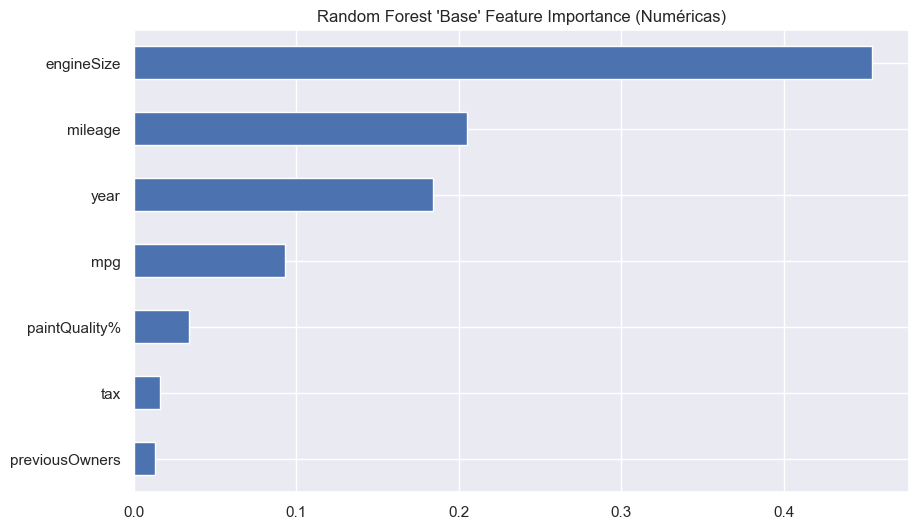

In [207]:
def analyze_rf_importance_numeric(X, y, numeric_list):
    base_rf = RandomForestRegressor(
        n_estimators=200, 
        random_state=42, 
        n_jobs=-1
    )
    base_rf.fit(X, y)
    importances = base_rf.feature_importances_
    coef_rf = pd.Series(importances, index=numeric_list)

    print("\nImportance of Numeric Features:")
    print(coef_rf.sort_values(ascending=False)) 
    plot_importance(coef_rf, "Random Forest 'Base' Feature Importance (Numéricas)")
    
    return coef_rf

rf_importances_numeric = analyze_rf_importance_numeric(X_train_num_scaled, y_train, metric_features)

### Conclusion of feature selection

Numerical Features

| Predictor       | Spearman | RFE Linear | Lasso  | Random Forest | What to do? |
|-----------------|----------|------------|--------|---------------|-------------|
| year            | Keep     | Keep       | Keep   | Keep          | Include in the model |
| mileage         | Keep     | Keep       | Keep   | Keep          | Include in the model |
| tax             | Keep     | Discard    | Discard| Discard       | Discard              |
| mpg             | Keep     | Keep       | Keep   | Keep          | Include in the model |
| engineSize      | Keep     | Keep       | Keep   | Keep          | Include in the model |
| paintQuality%   | Keep     | Discard    | Discard| Discard       | Discard              |  
| previousOwners  | Keep     | Discard    | Discard| Discard       | Discard              |

Categorical Features

| Predictor       | Chi-Square Result                | What do |
|-----------------|----------------------------------| -- |
| Brand           | Keep                             | Include in the model |
| model           | Keep                             | Include in the model |
| transmission    | Keep                             | Include in the model |
| fuelType        | Keep                             | Include in the model |

In [208]:
def remove_columns(dfs):
    columns_to_remove=["tax","paintQuality%","previousOwners"]
    for X in dfs:
        X=X.drop(columns_to_remove, axis=1, inplace=True)
    print('"tax","paintQuality%","previousOwners" columns were removed sucessfully.')

In [209]:
remove_columns(X_features_scaled)

"tax","paintQuality%","previousOwners" columns were removed sucessfully.


Based on our analysis, we decided to remove 3 features (in addition to hasDamage):
-   paintQuality%: Removed to prevent data leakage. This is a "mechanic's assessment," which would not be available to our model at the time of user prediction.
-   previousOwners: Removed (Embedded Method). LassoCV assigned it a coefficient of 0.0.
-   tax: Removed (Filter Method). It had a very high NaN count (7904) and high variance.

## Model Benchmarking and Optimization

### Test 1: benchmark with OrdinalEncoder

First, we benchmarked the 5 regression models using a simple OrdinalEncoder.

In [210]:
from sklearn.preprocessing import OrdinalEncoder
def aplicar_ordinal_encoder(X_train, X_val,X_test):
   
    encoder = OrdinalEncoder(
        handle_unknown='use_encoded_value', 
        unknown_value=-1,
        dtype=int
    )
    
    encoder.fit(X_train)
    
    for i, col in enumerate(X_train.columns):
        print(f"  {col}: {encoder.categories_[i]}")
    

    X_train_encoded = encoder.transform(X_train)
    

    X_val_encoded = encoder.transform(X_val)
    X_test_encoded = encoder.transform(X_test)
    
    return X_train_encoded, X_val_encoded, X_test_encoded

In [211]:
X_train_encoded, X_val_encoded, X_test_encoded=aplicar_ordinal_encoder(X_train_scaled,X_val_scaled,X_test_scaled)


  Brand: ['Audi' 'BMW' 'Ford' 'Hyundai' 'Mercedes' 'Opel' 'Skoda' 'Toyota' 'VW']
  model: [' Yet' '1 series' '2 series' '200' '230' '3 series' '4 series' '5 series'
 '6 series' '7 series' '8 series' 'a class' 'a1' 'a3' 'a4' 'a5' 'a6' 'a7'
 'a8' 'adam' 'agila' 'amarok' 'ampera' 'antara' 'arteon' 'astra' 'auris'
 'avensis' 'aygo' 'b class' 'b-max' 'beetle' 'c class' 'c-hr' 'c-max'
 'caddy life' 'caddy maxi life' 'california' 'camry' 'caravelle' 'cascada'
 'cc' 'citigo' 'cl class' 'cla class' 'clk' 'cls class' 'combo life'
 'corolla' 'corsa' 'crossland x' 'e class' 'ecosport' 'edge' 'eos' 'fabia'
 'fiesta' 'focus' 'fusion' 'g class' 'galaxy' 'getz' 'gl class'
 'gla class' 'glb class' 'glc class' 'gle class' 'gls class' 'golf'
 'golf sv' 'grand c-max' 'grand tourneo connect' 'grandland x' 'gt86'
 'gtc' 'hilux' 'i10' 'i20' 'i3' 'i30' 'i40' 'i8' 'i800' 'insignia' 'ioniq'
 'iq' 'ix20' 'ix35' 'jetta' 'ka+' 'kadjar' 'kamiq' 'karoq' 'kodiaq' 'kona'
 'kuga' 'land cruiser' 'm class' 'm2' 'm3' 'm4'

#### Model Evaluation

In [212]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(alpha=0.1, random_state=42), 
    "Ridge": Ridge(alpha=0.1, random_state=42),
    "Linear SVR": LinearSVR(random_state=42, max_iter=3000, dual="auto"), 
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1, max_depth=18, max_features= 0.7,min_samples_leaf= 5,min_samples_split= 10) 
}
results = {}

In [213]:
def running_models(X_train,y_train,X_val,y_val):
    for name, model in models.items():
        #training the model
        model.fit(X_train, y_train)

        #predicting with test data
        y_pred_val=model.predict(X_val)
        #metrics
        r2 = r2_score(y_val, y_pred_val)
        mae = mean_absolute_error(y_val, y_pred_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
        results[name] = {"R²": r2, "MAE": mae, "RMSE": rmse}
        print(f"\nResults for: {name}")
        print(f"  R²:   {r2:.4f}")
        print(f"  MAE:  {mae:.2f}")
        print(f"  RMSE: {rmse:.2f}")

In [214]:
running_models(X_train_encoded,y_train,X_val_encoded,y_val)


Results for: Linear Regression
  R²:   0.6061
  MAE:  4511.73
  RMSE: 6084.29

Results for: Lasso
  R²:   0.6061
  MAE:  4511.76
  RMSE: 6084.32

Results for: Ridge
  R²:   0.6061
  MAE:  4511.73
  RMSE: 6084.29

Results for: Linear SVR
  R²:   0.5900
  MAE:  4571.88
  RMSE: 6207.63

Results for: Random Forest
  R²:   0.7886
  MAE:  2635.35
  RMSE: 4457.19


### Test 2: pipeline with TargetEncoder

The OrdinalEncoder was not ideal for linear models. As an optimization, we switched to a pipeline featuring TargetEncoder. TargetEncoder converts categories into the mean of the target variable, providing much more informative input.

In [215]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

In [216]:
categorical_transformer = Pipeline(steps=[
    ('target_encoder', ce.TargetEncoder(
        cols=non_metric_features,
        handle_unknown='value',     
        handle_missing='value'    
    ))
])

In [217]:
#we need to remove this features as we have seen in the feature selection 
metric_features.remove("tax") 
metric_features.remove("paintQuality%")
metric_features.remove("previousOwners")

In [218]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, metric_features),    
        ('cat', categorical_transformer, non_metric_features)
    ],
    remainder='drop' #removes tax, paintQuality% and previousOwners
)

In [219]:
#fit train data
preprocessor.fit(X_train, y_train) 
#transform all X
X_train_FINAL = preprocessor.transform(X_train)
X_val_FINAL = preprocessor.transform(X_val)
X_test_FINAL = preprocessor.transform(X_test) 


#### Model Evaluation

In [220]:
running_models(X_train_FINAL,y_train,X_val_FINAL,y_val)


Results for: Linear Regression
  R²:   0.8092
  MAE:  2733.90
  RMSE: 4234.51

Results for: Lasso
  R²:   0.8092
  MAE:  2733.88
  RMSE: 4234.51

Results for: Ridge
  R²:   0.8092
  MAE:  2733.89
  RMSE: 4234.51

Results for: Linear SVR
  R²:   0.6257
  MAE:  3997.58
  RMSE: 5931.10

Results for: Random Forest
  R²:   0.9447
  MAE:  1357.86
  RMSE: 2278.93


### Conclusion of model benchmarking

After the pipeline with the TargetEncoder was applied, the models were re-evaluated. The RandomForestRegressor was confirmed as the best-performing model on the validation set.

| Model              | R² (R-squared) | MAE              | RMSE               |
| :----------------- | :------------- | :--------------- | :----------------- |
| **Random Forest**  | **0.9447** | **1357.86** | **2278.93** |
| Linear Regression  | 0.8092        | 2733.90          | 4234.51            |
| Lasso              | 0.8092        | 2733.88          | 4234.51            |
| Ridge              | 0.8092         | 2733.89          | 4234.51            |
| Linear SVR         | 0.6257         | 3997.58          | 5931.10            |

#### Hyperparameter tuning with GridSearchCV

To further optimize model performance and find the most suitable hyperparameters for our chosen models, we initiated Hyperparameter Tuning using GridSearchCV.

In [221]:

rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)

param_grid_rf = { #parameters for random forest
    'n_estimators': [200, 300, 400], 
    'max_depth': [16, 18, 20, 22],     
    'min_samples_leaf': [2, 3, 4, 5],   
    'min_samples_split': [5, 8, 10],   
    'max_features': [0.7, 0.8, 'sqrt']
}

grid_search_rf = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid_rf,
    cv=5,
    scoring='r2',
    n_jobs=-1, # Uses all processors
    verbose=1  #show output
)

grid_search_rf.fit(X_train_FINAL, y_train)


print(f"Best R² for Random Forest: {grid_search_rf.best_score_:.4f}")
print(f"Best parameters: {grid_search_rf.best_params_}\n")


best_overall_model = grid_search_rf.best_estimator_
best_overall_name = "Random Forest (Tuned)"

print(f"Metrics of ({best_overall_name}) in VAL:")


y_pred_val = best_overall_model.predict(X_val_FINAL)

r2_final = r2_score(y_val, y_pred_val)
mae_final = mean_absolute_error(y_val, y_pred_val)
rmse_final = np.sqrt(mean_squared_error(y_val, y_pred_val))

print(f"R²: {r2_final:.4f}")
print(f"MAE: {mae_final:.2f}")
print(f"RMSE: {rmse_final:.2f}")

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


KeyboardInterrupt: 

## Conclusion and Kaggle submission

The Random Forest Regressor was the winner with R² = 0.9436. 

Below, we use the final pipeline and generate the 'submission.csv' file.

In [ ]:
#y_test=models["Random Forest"].predict(X_test_FINAL)
y_test = best_overall_model.predict(X_test_FINAL)
submission = pd.DataFrame({
    'carID': test.index,
    'price': y_test.astype("int")
})
submission.to_csv('submission.csv', index=False)